# CONVENTIONAL NEURAL NETWORKS FOR THE SEARCH OF SUPERSYMMETRIC PARTICLES

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras import Sequential

This is the second part of the Logistic Regression we elaborated before. In this notebook we are going to explore a different Machine Learning branch to try to improve the results for the SUSY dataset obtained with Logistic Regressión: Deep Learning methods, precisely, a Conventional Neural Network (CNN).

This time we are going to use Keras libraries, and maybe if the results are optimal, I could code a neural network from scratch.

A conventional neural network can be pictured as follows: (figure from https://www.tibco.com/reference-center/what-is-a-neural-network)

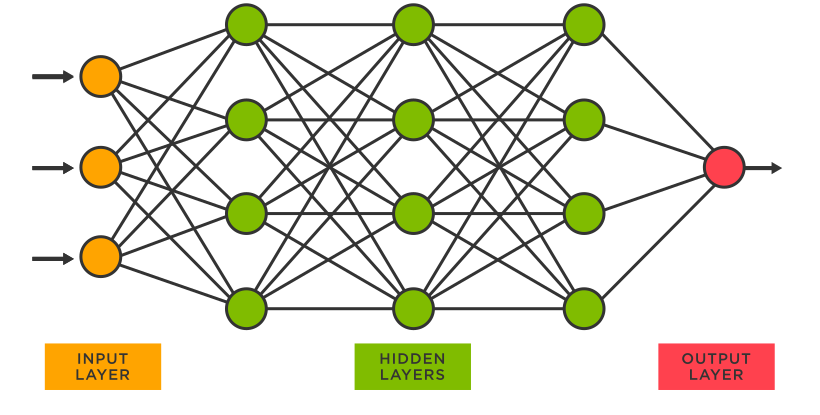

It consists of an input layer, where we are going to input all our features (then the input layer is going to have 18 neurons). Then, we have the hidden layers, whose number we are going to determine through a grid search again. The number of neuron per layer is going to be grid searched too. And finally the output layer: in our case is going to have one neuron, which is going to output the probability to obtain a result of 1 (signal).

All neurons from a layer is connected to all the neurons from the previous layer and to all the neurons from the next layer. If we focus in the image, the first neuron of the first hidden layer is conected to all input neurons and to the neurons of the second hidden layer. This first neuron contains information from the input layer, precisely, weights of all the neurons (matrix w as in the previous notebook) and a bias (or intercept as before). The aim of the neural network is to obtain the optimal weights and bias so the accuracy is best. Because of all before, the number of parameters to train can be very high, and will depend on the number of hidden layers and hidden neurons per layer.

With the parameters about the previous layers, each neuron is going to output the result of an Activation Function. In this case we are going to use ReLu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks) as activation function for hidden neurons in order to introduce non-linearity to the model, and the sigmoid for the output neurons. The loss function used to train the network is going to be again the Binary Cross Entropy loss function and as optimizer, Adam or Stocastic Gradient Descent (SGD).

There isn't a general rule to the perfect combination of layers and neurons, so a grid search is going to be performed.
Again, due to equipment limitations, I will focus on a reduced subset of the dataset and also not too many hidden layers/neurons are going to be tried.

## Data preparation

In [17]:
n_train = 2000000
n_features = 18

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]
df = pd.read_csv("SUSY.csv", names=columns, header=None)

Preprocessing data is crucial for a suitable performance of the neural network.

In [18]:
scaler = preprocessing.StandardScaler()
scaler.fit(df.iloc[0:n_train+n_test, 1:]) #we omit the first colum (signal)
df_proc = scaler.transform(df.iloc[0:n_train+n_test, 1:])

#we check the data is properly normalized and standardized
scaler.fit(df_proc)
print("Means: (should be 0 or very very close)")
print(scaler.mean_) 
print("Variances: (should be 1)")
print(scaler.var_)

Means: (should be 0 or very very close)
[-1.15482379e-16 -1.44581236e-17  1.13800525e-17  1.80321535e-17
 -1.68512315e-17  1.65442771e-17 -8.73541239e-17  3.33230332e-17
  8.02198485e-16  4.83169060e-19 -1.00274633e-16 -7.09533765e-17
 -2.10241069e-16 -1.28494548e-16 -6.85304258e-17 -1.44950718e-19
  1.59037654e-15 -3.83465704e-16]
Variances: (should be 1)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [167]:
#We split into features and labels
X_train = df_proc[0:n_train]
y_train = df.iloc[0:n_train, 0]

#this time we are going to include both test and train data in the same variable, and when fitting the model we will split it directly as it will be shown.

## Building the model

As we are going to perform a grid search, I am going to define a function who builds a neural network from the desired number of hidden layers and number of hidden neurons (hyperparameters):

In [25]:
def build_model(n_hl, n_hn, opt):
    
    model = Sequential()
    model.add(Dense(18, input_dim=18)) #input layer
    
    for i in range(n_hl):
        model.add(Dense(n_hn, activation='relu')) #hidden layers
        
    model.add(Dense(1, activation='sigmoid')) #output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

## Grid search
Once the builder is done we define the hyperparameters we are going to try to find the best model and then train all of them.

In [72]:
ns_hl = [1,2,5]
ns_hn = [2,5,10]
optimizers = ["adam", "SGD"]

#A dictionary to store all the models. model_dict[i,j,k] will refer to the model with optimizer i, j hidden layers and k hidden neurons 
models_dict = {}
#Another dictionary to store all the model's history. The indexing is the same as models_dict
models_hist = {}

for i in optimizers:
    for j in ns_hl:
        for k in ns_hn:
            print(i,j,k)
            models_dict[i,j,k] = build_model(j,k,i)
            models_hist[i,j,k] = models_dict[i,j,k].fit(X_train, y_train, validation_split=0.25, batch_size=32, epochs=10, callbacks=tf.keras.callbacks.EarlyStopping(patience=0)).history
            #the early stopping is a regularization method, it will stop the training if there's no improvement of accuracy with epochs anymore

adam 1 2
Epoch 1/10
46875/46875 [==============================] - 90s 2ms/step - loss: 0.4523 - accuracy: 0.7882 - val_loss: 0.4491 - val_accuracy: 0.7894
Epoch 2/10
46875/46875 [==============================] - 101s 2ms/step - loss: 0.4494 - accuracy: 0.7897 - val_loss: 0.4492 - val_accuracy: 0.7889
adam 1 5
Epoch 1/10
46875/46875 [==============================] - 100s 2ms/step - loss: 0.4389 - accuracy: 0.7969 - val_loss: 0.4357 - val_accuracy: 0.7986
Epoch 2/10
46875/46875 [==============================] - 95s 2ms/step - loss: 0.4344 - accuracy: 0.7991 - val_loss: 0.4338 - val_accuracy: 0.7995
adam 1 10
Epoch 1/10
46875/46875 [==============================] - 97s 2ms/step - loss: 0.4361 - accuracy: 0.7984 - val_loss: 0.4328 - val_accuracy: 0.7998
Epoch 2/10
46875/46875 [==============================] - 94s 2ms/step - loss: 0.4323 - accuracy: 0.8006 - val_loss: 0.4309 - val_accuracy: 0.8009
adam 2 2
Epoch 1/10
46875/46875 [==============================] - 100s 2ms/step - loss:

We can plot the results for a further analysis. For that, a function for a 3D plot can be set up first.

In [164]:
def plot3D(optimizer):
    x_ax = []
    y_ax = []
    z_ax = []
    
    if optimizer == 'adam':
        depth=0.5
    else:
        depth=0.79

    for j in ns_hl:
        for k in ns_hn:
            x_ax.append(j)
            y_ax.append(k)                                  
            z_ax.append(models_hist[optimizer,j,k]['accuracy'][1]) #we get accuracy for the second epoch only

    fig = plt.figure(optimizer)
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x_ax, y_ax, z_ax)

    for x, y, z in zip(x_ax, y_ax, z_ax):
        ax.plot([x, x], [y, y], [depth, z], color='black', linestyle='dotted')

    ax.set_title("Accuracies obtained with optimizer: "+optimizer)
    ax.set_zlim(depth,0.805)
    ax.set_xlabel('Hidden Layers')
    ax.set_ylabel('Hidden Nodes')
    ax.set_zlabel('Accuracy')
    plt.show()
        
    return

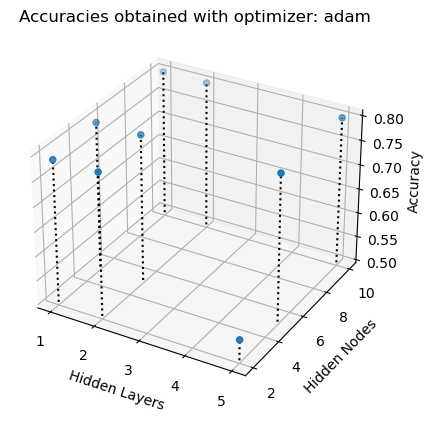

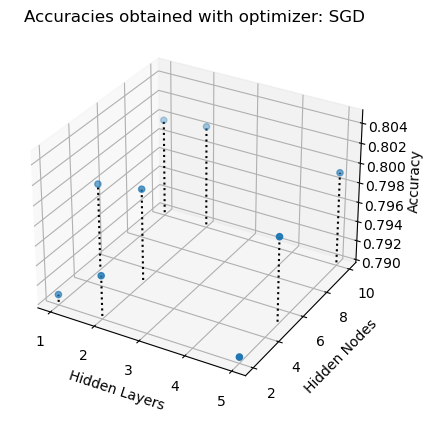

In [165]:
plot3D("adam")
plot3D("SGD")

We obtained very similar results for almost all configurations. It seems that SGD works better than adam in this case, even performing satisfactory with a only 1 hidden layer and 2 hidden neurons. All data has not been used during the training, so maybe taking into account the whole dataset, results may be different.

We see that there's no improvement at all if the model gets complexer (except if we choose adam as optimizer, we got an accuracy of 50% for one hidden layer and two hidden neurons), even though the number of paramenters to train, and hence training time, is greater.

We can take as example $models\_dict['SGD',5,10]$: The number of parameters to train are (18+1)·10+(10+1)·10·4+11=641.

Meanwhile model $models\_dict['SGD',1,2]$ just have to train (18+1)·2+3=41 parameters (94% less).

The results for both are almost the same in accuracy. As there's almost no different in training time, for the subset of the dataset chosen, I would chose $models\_dict['SGD',1,5]$ or $models\_dict['SGD',2,5]$ to predict data, both with an accuracy of $\approx$80% and training times around one and a half minute.